In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numba import njit,prange
import random
from collections import Counter

In [8]:

# CTW code written by Gabe Schamberg (https://github.com/gabeschamberg/context-tree-weighting)

# The rest of code by Kamaludin Dingle (Caltech 2022)

class CTW:
    def __init__(self,depth,symbols=2,sidesymbols=1,staleness=0):
        # tree depth
        self.D = depth
        # number of predicted symbols (for keeping counts)
        self.M = symbols
        # number of recent sideinfo samples to ignore
        self.K = staleness
        # number of symbols with side info (for contexts)
        self.Mtot = symbols*sidesymbols
        # create list of "restricted" contexts (no side info)
        self.rcontexts = range(symbols)
        # create list of "complete" contexts (w/ side info)
        self.ccontexts = []
        for x in range(symbols):
            for y in range(sidesymbols):
                self.ccontexts.append((x,y))
        # keep track of leaf nodes
        self.leaves = {}
        # create root (which in turn creates tree)
        self.root = Node(parent=None,context=[],ctw=self)
        # initialize distribution
        self.distribution = np.ones((symbols,))/symbols

    def set_distribution(self,distribution):
        self.distribution = distribution

    def get_distribution(self):
        return self.distribution

    def add_leaf(self,node):
        self.leaves[str(node.context)] = node

    def update(self,symbol,context):
        leaf = self.leaves[str(context)]
        leaf.update(symbol)

    def predict_sequence(self,seq,sideseq=None):
        # create a matrix of distributions (columns->samples,rows->symbols)
        if type(seq) == str:
            seq= [int(x) for x in seq]

        distributions = np.zeros((self.M,len(seq)-self.D))
        # use first d symbols as context
        if sideseq is None:
            context = [seq[d] for d in reversed(range(self.D))]
        else:
            ccontext = [(seq[d],sideseq[d]) for d in reversed(range(self.D))]
            context = ccontext.copy()
            if self.K > 0:
                for k in range(self.K):
                    context[k] = ccontext[k][0]
        # loop though samples
        for n,x in enumerate(seq[self.D:]):
            # update the appropriate nodes for current context
            self.update(x,context)
            # get the distribution for the next symbol
            distributions[:,n] = self.get_distribution()
            # update the context
            if sideseq is None:
                context.insert(0,x)
                context = context[:self.D]
            else:
                ccontext.insert(0,(x,sideseq[n+self.D]))
                ccontext = ccontext[:self.D]
                context = ccontext.copy()
                if self.K > 0:
                    for k in range(self.K):
                        context[k] = ccontext[k][0]
        return distributions

class Node:
    def __init__(self,ctw,context,parent):
        self.ctw = ctw
        self.counts = np.zeros((self.ctw.M,))
        self.context = context
        self.parent = parent
        self.beta = 1
        if self.context == []:
            self.root = True
        else:
            self.root = False
        if len(self.context) == self.ctw.D:
            self.leaf = True
            self.ctw.add_leaf(self)
        else:
            self.leaf = False
        if not self.leaf:
            # if using side info, compare depth to staleness
            if (self.ctw.Mtot > self.ctw.M) and \
                        (len(self.context) >= self.ctw.K):
                contexts = self.ctw.ccontexts
            # otherwise just create context based on symbols
            else:
                contexts = self.ctw.rcontexts
            # create all the children
            self.children = []
            for c in contexts:
                self.children.append(Node(
                        ctw=ctw,
                        context=context+[c],
                        parent=self))

    def update(self,symbol,etain=None):
        # if we are at a leaf node with no incoming eta
        if etain is None:
            etain = (self.counts[:-1]+0.5)/(self.counts[-1]+0.5)
        # get the number of symbols
        M = self.counts.size
        # find the weighted probabilities using incoming eta
        pw = np.append(etain,1)
        pw = pw/sum(pw)
        # find the kt estimates
        pe = (self.counts + 0.5)/(sum(self.counts)+0.5*M)
        # compute outgoing eta
        etaout = (self.beta*pe[:-1]+pw[:-1])/(self.beta*pe[-1]+pw[-1])
        # update beta
        self.beta *= pe[symbol]/pw[symbol]
        # update counts
        self.counts[symbol] += 1
        # if not root, pass outgoing eta up
        if not self.root:
            self.parent.update(symbol,etaout)
        # if we are at the root, set the ctw distribution
        else:
            etasum = sum(etaout) + 1
            self.ctw.set_distribution(np.append(etaout,1)/etasum)

In [19]:
d_max = 5 # makes a big difference to computation time



def comp_from_ctw(seq):
    if type(seq) == str:
        seq = [int(x) for x in seq]
    ctw_inst = CTW(depth=2,symbols=2)
    prd = ctw_inst.predict_sequence(seq=seq)
    res = 1
    print(prd)
    for i,num in enumerate(seq[2:]):
        res*=prd[num][i]
    res *=0.25
    proba = res
    return (np.log(1/proba)/np.log(2))

comp_from_ctw("010101")


[[0.5        0.625      0.66666667 0.34375   ]
 [0.5        0.375      0.33333333 0.65625   ]]


5.60768257722124

In [10]:
def KC_LZ(string):
    n = len(string)
    s = '0'+string
    c = 1
    l = 1
    i = 0
    k = 1
    k_max = 1

    while True:
        if s[i+k] != s[l+k]:
            if k > k_max:
                k_max = k
            i += 1
            if i == l:
                c += 1
                l += k_max
                if l+1 > n:
                    break
                else:
                    i = 0
                    k = 1
                    k_max = 1
            else:
                k = 1
        else:
            k += 1
            if l+k > n:
                c += 1
                break
    # a la Lempel and Ziv (IEEE trans inf theory it-22, 75 (1976),
    # h(n)=c(n)/b(n) where c(n) is the kolmogorov complexity
    # and h(n) is a normalised measure of complexity.
    complexity = c
    # b=n*1.0/np.log2(n)
    # complexity=c/b;
    return complexity


In [11]:

def calc_KC78(x):
    # x is the input string to compress
    x = str(x)

    # length of input string
    len_x=len(x)
    
    # number of different characters in string (i.e. size of alphabet). We set the smallerst alphabet to be 2 (i.e. binary)
    alpha = np.max([len(set(x)),2])

    # Initialise empty dictionary
    Dict = []

    # k is the value we have read up until
    k = 0

    # w is the length of the block that we read
    w = 0

    while k+w<=len_x:
        # r current substring of x
        r = x[k:k+w]

        if r in Dict:
            w = w + 1
        else:
            Dict.append(r)
            k = k + w
            w = 0

    # The "remove" is because the algorithm counts '' as a word
    Dict.remove('')
    #print(Dict)
    c78 = len(Dict)
    K78 = c78*(np.log2(c78)+np.log2(alpha))
    return np.round(K78,decimals=2)


In [12]:
def calc_KC76(s):
    L = len(s)
    if s == '0'*L or s == '1'*L:
        return np.log2(L)
    else:
        return np.log2(L)*(KC_LZ(s)+KC_LZ(s[::-1]))/2.0

In [17]:
s ="0000000000000000000000000000000000000000000000000000000000000000000000"
print(comp_from_ctw(s))
print(calc_KC76(s))

3.872131474408514
6.129283016944966


In [42]:
methods = {
    "LZ78":calc_KC78,
    "LZ76": calc_KC76,
    "CTW": comp_from_ctw
}

In [43]:
@njit
def discretize(arr):
    return list(map(round,arr))
@njit
def to_bin(arr):
    return ''.join(list(map(str,arr)))

@njit
def f(x,r):
    return r * x * (1-x)

@njit
def logistic_map(x_0,r,iterations,epsilon=0,e_freq=0):
    assert r>0 
    assert r < 4
    res = [x_0]
    cur = x_0
    for i in range(iterations-1):
        cur = f(cur,r)

        # When kick occurs
        if np.random.rand() < e_freq:
            added_eps = np.random.uniform(-epsilon,epsilon)
            # Keep sampling for epsilon until we get a valid value
            while  0>= cur + added_eps or cur + added_eps>=1:
                added_eps = np.random.uniform(-epsilon,epsilon)
            cur += added_eps
        assert 0< cur <1
        res.append(cur)
    return res

In [44]:
SAMPLES = 10**5

@njit
def generate_patterns(iterations,epsilon=0,e_freq=0,r=-1):

    '''Return list of patterns  from random `r` and `x_0`. patterns are of length `iterations`
        If r parameter is provided it will use that as the initial value of r, otherwise it will be random.
    
    '''
    r_is_random = r == -1
    patterns = [''] *(SAMPLES) 
    # patterns = np.empty(SAMPLES,dtype='object')
    for i in prange(SAMPLES):
        if (r_is_random):
            r = random.uniform(0,4)
        x_0 = np.random.rand()
        mapp = logistic_map(x_0,r,iterations,epsilon=epsilon,e_freq=e_freq)
        patterns[i] = to_bin(discretize(mapp))
    return patterns


In [45]:
def generate_logistic(iterations,start_iteration=0,epsilon=0,e_frequency=0,r=-1):
    ''' Wrapper function for logicstic map generation with kick.

    Parameters:
        `iterations`: the number of iterations that will be taken into account, this will determine the length of the pattern.
        `start_iteration`: after what iteration to start observing the pattern. defaults to `0`.
        `epsilon`: The magnitude of the random kick applied, when 0.5 is passed, the kick will be between -0.5,0.5. default to 0
        `e_frequency`: Nonnegative number determining the frequency of the kick. defaults to 0.
                       If the number is in the range [0,1), this is a probability.
    '''
                       # Otherwise it represents the frequency of the kick (1 means every time, 2 means every two time [nokick,kick,nokick,kick]) NOT IMPLEMENTED
    patterns = generate_patterns(start_iteration+iterations,epsilon=epsilon,e_freq=e_frequency,r=r)
    patterns = [ pattern[start_iteration:] for pattern in patterns]
    return patterns

In [46]:
def calc_SB(X,y):
     return np.polyfit(X,y,1);

In [47]:
n_iterations = 25
start_iteration=0
epsilon = 0.5
e_frequency = 0.1
r =3

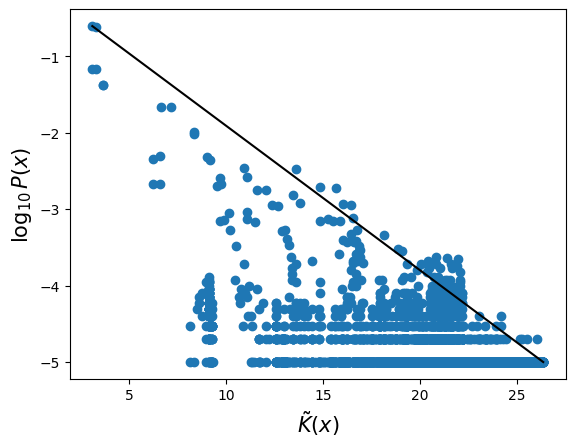

In [53]:
# # Generate figure for each epsilon value
# # %prun generate_logistic(n_iterations,start_iteration=1000,epsilon=epsilon,e_frequency=e_frequency,r=r)
patterns = generate_logistic(n_iterations,start_iteration=start_iteration,epsilon=epsilon,e_frequency=e_frequency,r=r)
counts = Counter(patterns)

probability = counts.copy()
probability = {k: v/SAMPLES for k,v in probability.items()}

probability_values =  list(probability.values())
complexities = list(map(comp_from_ctw,probability.keys()))
plt.figure()
plt.scatter(complexities,np.log10(probability_values))
plt.xlabel(r'$\mathit{\tilde{K}(x)}$',fontsize=15)
plt.ylabel(r'$\mathit{\log_{10} P(x)}$',fontsize=15)
x = [min(complexities),max(complexities)]
y = np.log10([max(probability_values),min(probability_values)])
plt.plot(x,y,c="k")

# # # plt.savefig(f"fixed_r/{r}.png")

In [49]:
# # Generate figure for each epsilon value
# # %prun generate_logistic(n_iterations,start_iteration=1000,epsilon=epsilon,e_frequency=e_frequency,r=r)
# patterns = generate_logistic(n_iterations,start_iteration=start_iteration,epsilon=epsilon,e_frequency=e_frequency,r=r)
# counts = Counter(patterns)

# probability = counts.copy()
# probability = {k: v/SAMPLES for k,v in probability.items()}

# probability_values =  list(probability.values())
# complexities = list(map(calc_KC76,probability.keys()))
# plt.figure()
# plt.scatter(complexities,np.log10(probability_values))
# # # plt.savefig(f"fixed_r/{r}.png")

In [54]:

methods = ["LZ76","LZ78","CTW"]
# plt.figure()
plt.figure()
results = []
method = "CTW"
for start_iteration in [0,1000]:
    for epsilon in [0.01,0.1,0.25,0.4,0.5,0.75]:
        for e_frequency in [0.1,0.5,1]:
            for r in [-1,2,2.5,3,3.65]:
                patterns = generate_logistic(n_iterations,start_iteration=start_iteration,epsilon=epsilon,e_frequency=e_frequency,r=r)
                probability = Counter(patterns)
                probability = {k: v/SAMPLES for k,v in probability.items()}
                probability_values =  list(probability.values())
                complexities = list(map(comp_from_ctw,probability.keys()))
                df = pd.DataFrame({"y":probability_values,'x':complexities})
                groupmax = df.groupby('x').max().reset_index()
                ar = calc_SB(groupmax['x'],np.log10(groupmax['y']))#
                slope = ar[0]
                plt.clf()
                plt.scatter(complexities,np.log10(probability_values))
                # plt.title(f"start={start_iteration}, eps={epsilon}, e_freq={e_frequency}, r={r}, KC_method={method}")
                plt.xlabel(r'$\mathit{\tilde{K}(x)}$',fontsize=15)
                plt.ylabel(r'$\mathit{\log_{10} P(x)}$',fontsize=15)
                x = [min(complexities),max(complexities)]
                y = np.log10([max(probability_values),min(probability_values)])
                plt.plot(x,y,c="k")
                plt.savefig(f"output/{method}/{start_iteration}_{epsilon}_{e_frequency}_{r}.jpg")
                
                row = [ start_iteration,epsilon,e_frequency,r,slope] 
                print(row)
                results.append(row)
                del patterns 
                del probability 
                del probability_values 
    pd.DataFrame(results,columns=["start_iteration","epsilon","e_frequency","r","slope_CTW"]).to_csv("resultsCTW.csv")

[0, 0.01, 0.1, -1, -0.06373556627266076]
[0, 0.01, 0.1, 2, -0.12417961766742672]
[0, 0.01, 0.1, 2.5, -0.4711924307369242]
[0, 0.01, 0.1, 3, -0.5181381997333221]
[0, 0.01, 0.1, 3.65, -0.01275486021144756]
[0, 0.01, 0.5, -1, -0.05947880579606339]
[0, 0.01, 0.5, 2, -0.04037413895813767]
[0, 0.01, 0.5, 2.5, -0.4809364334672263]
[0, 0.01, 0.5, 3, -0.45107963011931457]
[0, 0.01, 0.5, 3.65, -0.008613765055747435]
[0, 0.01, 1, -1, -0.06145394535166518]
[0, 0.01, 1, 2, 0.005622481579863912]
[0, 0.01, 1, 2.5, -0.4943826764360938]
[0, 0.01, 1, 3, -0.517907508832361]
[0, 0.01, 1, 3.65, -0.006473663050136233]
[0, 0.1, 0.1, -1, -0.0614449428107539]
[0, 0.1, 0.1, 2, -0.130811349011965]
[0, 0.1, 0.1, 2.5, -0.2607459818731244]
[0, 0.1, 0.1, 3, -0.2225082941388716]
[0, 0.1, 0.1, 3.65, -0.03950278957249127]
[0, 0.1, 0.5, -1, -0.046768459118708784]
[0, 0.1, 0.5, 2, -0.036735916060869414]
[0, 0.1, 0.5, 2.5, -0.1684012086493289]
[0, 0.1, 0.5, 3, -0.16105133226821272]
[0, 0.1, 0.5, 3.65, -0.02252115603679654

IndexError: list index out of range

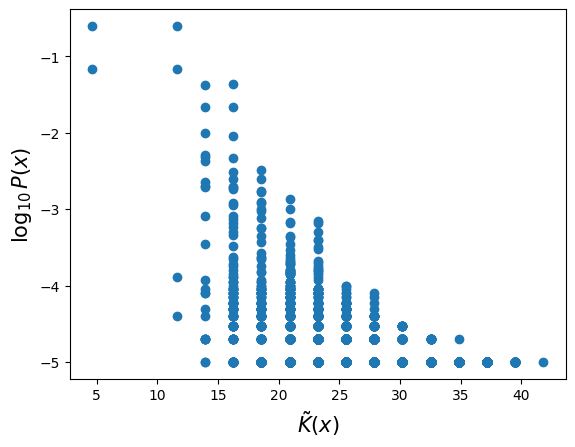

In [ ]:

# methods = ["LZ76","LZ78","CTW"]
# # plt.figure()
# plt.figure()
# results = []
# for start_iteration in [0,1000]:
#     for epsilon in [0.01,0.1,0.25,0.4,0.5,0.75]:
#         for e_frequency in [0.1,0.5,1]:
#             for r in [-1,2,2.5,3,3.65]:
#                 patterns = generate_logistic(n_iterations,start_iteration=start_iteration,epsilon=epsilon,e_frequency=e_frequency,r=r)
#                 probability = Counter(patterns)
#                 probability = {k: v/SAMPLES for k,v in probability.items()}
#                 probability_values =  list(probability.values())
#                 slopes = [-1,-1,-1]
#                 for i, KC_method in enumerate([calc_KC76,calc_KC78,comp_from_ctw]):
#                     method = methods[i]
#                     complexities = list(map(KC_method,probability.keys()))
#                     df = pd.DataFrame({"y":probability_values,'x':complexities})
#                     groupmax = df.groupby('x').max().reset_index()
#                     ar = calc_SB(groupmax['x'],np.log10(groupmax['y']))#
#                     slope = ar[0]
#                     slopes[i] = slope
#                     plt.clf()
#                     plt.scatter(complexities,np.log10(probability_values))
#                     # plt.title(f"start={start_iteration}, eps={epsilon}, e_freq={e_frequency}, r={r}, KC_method={method}")
#                     plt.xlabel(r'$\mathit{\tilde{K}(x)}$',fontsize=15)
#                     plt.ylabel(r'$\mathit{\log_{10} P(x)}$',fontsize=15)
#                     plt.savefig(f"output/{method}/{start_iteration}_{epsilon}_{e_frequency}_{r}.jpg")
                
#                 row = [ start_iteration,epsilon,e_frequency,r] + slopes
#                 print(row)
#                 results.append(row)
#                 del patterns 
#                 del probability 
#                 del probability_values 
#     pd.DataFrame(results,columns=["start_iteration","epsilon","e_frequency","r","slope_KC76","slope_KC78","slope_CTW"]).to_csv("resultsCTW.csv")